Starting hyperparameter tuning using cross-validation...
New best model - CV Accuracy: 0.8336, Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2}
New best model - CV Accuracy: 0.8342, Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4}
New best model - CV Accuracy: 0.8342, Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 8}
New best model - CV Accuracy: 0.8355, Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10}
New best model - CV Accuracy: 0.8356, Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2}
New best model - CV Accuracy: 0.8363, Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4}
New best model - CV Accuracy: 0.8371, Params: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4}

Training best model on full training set...

Evaluating best model on test set...


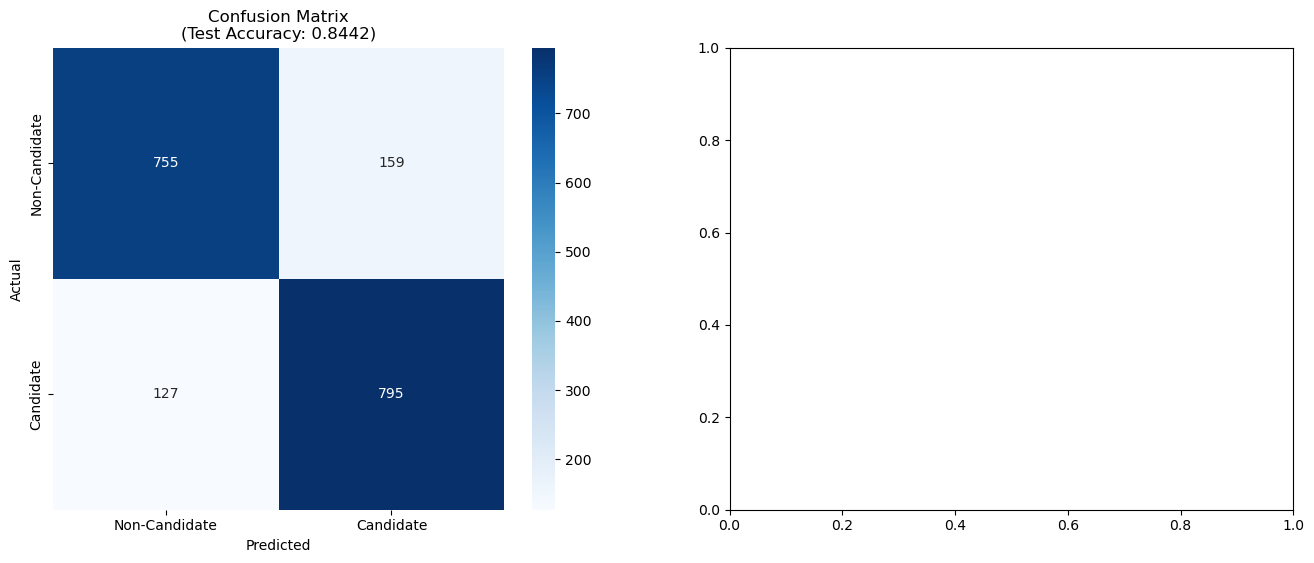

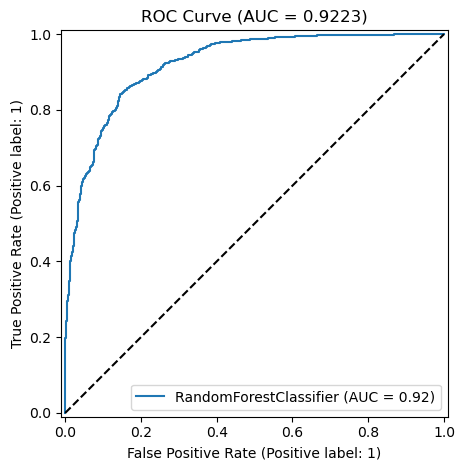


=== Best Model Summary ===
Best Parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4}
Cross-Validation Accuracy: 0.8371
Test Accuracy: 0.8442
Test ROC AUC: 0.9223

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       914
           1       0.83      0.86      0.85       922

    accuracy                           0.84      1836
   macro avg       0.84      0.84      0.84      1836
weighted avg       0.84      0.84      0.84      1836



In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, 
                            roc_auc_score, accuracy_score, RocCurveDisplay)
from sklearn.model_selection import train_test_split, cross_val_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
short_cols = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
              'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

data = pd.read_csv('KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')
data['ExoplanetCandidate'] = data['koi_pdisposition'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
data = data[short_cols].dropna()
data.to_csv('KOI_2025.07.31_cleaned.csv')

# Prepare features and target
X = data.drop(columns=['ExoplanetCandidate'])
y = data['ExoplanetCandidate']

# Split and scale data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=10, 
    test_size=0.2, 
    stratify=y
)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
joblib.dump(scaler, 'scaler_ksmet.sav')

# Initialize variables for best model tracking
best_model = None
best_score = 0
best_params = {}
results = []

# Parameter ranges to test
n_estimators_range = range(100, 500, 50)
min_samples_split_range = [2, 5, 10]
min_samples_leaf_range = [2, 4, 8, 10, 12]

# Nested loop for hyperparameter tuning (using only CV scores)
print("Starting hyperparameter tuning using cross-validation...")
for n_est in n_estimators_range:
    for min_split in min_samples_split_range:
        for min_leaf in min_samples_leaf_range:
            
            model = RandomForestClassifier(
                n_estimators=n_est,
                min_samples_split=min_split,
                min_samples_leaf=min_leaf,
                random_state=10,
                bootstrap=False,
                class_weight='balanced',
                n_jobs=-1
            )
            
            # Only use cross-validation for model selection
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
            mean_cv = np.mean(cv_scores)
            
            # Track results (without test scores)
            results.append({
                'n_estimators': n_est,
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf,
                'cv_score': mean_cv
            })
            
            # Update best model based on CV score only
            if mean_cv > best_score:
                best_score = mean_cv
                best_params = {
                    'n_estimators': n_est,
                    'min_samples_split': min_split,
                    'min_samples_leaf': min_leaf
                }
                print(f"New best model - CV Accuracy: {mean_cv:.4f}, Params: {best_params}")

# Save tuning results
results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

# Train the best model on full training data
print("\nTraining best model on full training set...")
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=10,
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1
)
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'best_tuned_rf_model.sav')

# Evaluate on test set (only after model selection)
print("\nEvaluating best model on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_proba)

# Performance visualization
plt.figure(figsize=(16, 6))

# Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, cmap="Blues", fmt="d",
            xticklabels=['Non-Candidate', 'Candidate'],
            yticklabels=['Non-Candidate', 'Candidate'])
plt.title(f"Confusion Matrix\n(Test Accuracy: {test_accuracy:.4f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# ROC Curve
plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"ROC Curve (AUC = {test_roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')

plt.tight_layout()
plt.savefig('best_model_performance.png', dpi=300)
plt.show()

# Final model summary
print("\n=== Best Model Summary ===")
print(f"Best Parameters: {best_params}")
print(f"Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Top Performing Configuration:
 n_estimators  min_samples_split  min_samples_leaf  cv_score
          150                 10                 4    0.8371


C:\Users\huangm\AppData\Local\Temp\ipykernel_7948\370224521.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


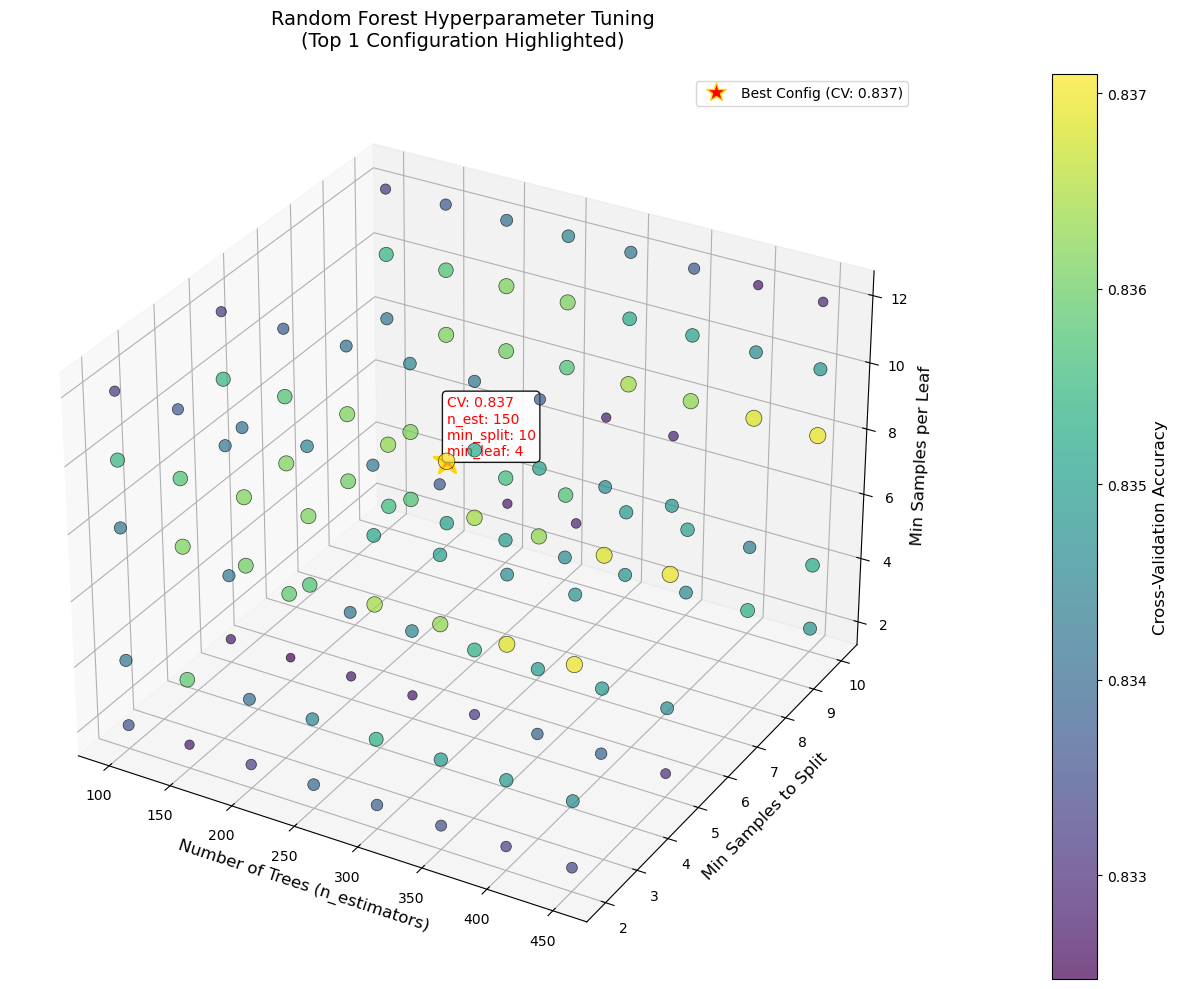

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Load CSV
df = pd.read_csv('hyperparameter_tuning_results.csv')

# Get top 1 configuration and print it
top1 = df.nlargest(1, 'cv_score')
print("Top Performing Configuration:")
print(top1[['n_estimators', 'min_samples_split', 'min_samples_leaf', 'cv_score']].to_string(index=False, header=True))

# Create figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Enhanced colormap
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=df['cv_score'].min(), vmax=df['cv_score'].max())

# Plot all points
sc = ax.scatter(
    df['n_estimators'],
    df['min_samples_split'],
    df['min_samples_leaf'],
    c=df['cv_score'],
    cmap=cmap,
    norm=norm,
    s=40 + 100*(df['cv_score'] - df['cv_score'].min())/(df['cv_score'].max() - df['cv_score'].min()),
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# Highlight ONLY the top 1 point
ax.scatter(
    top1['n_estimators'],
    top1['min_samples_split'],
    top1['min_samples_leaf'],
    c='red',
    marker='*',
    s=400,  # Extra large size
    edgecolor='gold',
    linewidth=2,
    alpha=1,
    label=f'Best (CV: {top1["cv_score"].values[0]:.3f})',
    zorder=10
)

# Add label to top point
ax.text(top1['n_estimators'].values[0], 
        top1['min_samples_split'].values[0], 
        top1['min_samples_leaf'].values[0]*1.05,
        f"CV: {top1['cv_score'].values[0]:.3f}\n"
        f"n_est: {top1['n_estimators'].values[0]}\n"
        f"min_split: {top1['min_samples_split'].values[0]}\n"
        f"min_leaf: {top1['min_samples_leaf'].values[0]}",
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round'))

# Colorbar
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Cross-Validation Accuracy', fontsize=12)

# Custom legend
legend_elements = [
    Line2D([0], [0],
           marker='*',
           color='w',
           markerfacecolor='red',
           markeredgecolor='gold',
           markersize=15,
           label=f'Best Config (CV: {top1["cv_score"].values[0]:.3f})')
]
ax.legend(handles=legend_elements, loc='upper right')

# Axis labels
ax.set_xlabel('Number of Trees (n_estimators)', fontsize=12)
ax.set_ylabel('Min Samples to Split', fontsize=12)
ax.set_zlabel('Min Samples per Leaf', fontsize=12)

# Title
plt.title('Random Forest Hyperparameter Tuning\n(Top 1 Configuration Highlighted)', 
          fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('RF_Top1_Configuration.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Feature importance analysis
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

# Cross-validation results for the best model
cv_results = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print("\nCross-validation results (accuracy):", cv_results)
print(f"Mean cross-validation accuracy: {np.mean(cv_results):.4f} (±{np.std(cv_results):.4f})")